# INA Project: Spotify link prediction

Faculty of Computer and Information Science, University of Ljubljana

May 2024

Maja Kolar, Blaž Pridgar, Jure Savnik

## IMPORTS

In [75]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random
import re

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [76]:
# Import relevant ML libraries
from typing import Optional, Union

from cdlib import algorithms

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.3.0; Torch-cuda version: None; Torch Geometric version: 2.5.3.


In [77]:
# set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Processing data

### Loading data from the source

In [4]:
DATA_DIR = "spotify_million_playlist_dataset/data"

In [5]:
with open(f"{DATA_DIR}/{os.listdir(DATA_DIR)[1]}") as jf:
  print(jf)
  example_file = json.load(jf)

print(example_file['playlists'][0])

<_io.TextIOWrapper name='spotify_million_playlist_dataset/data/mpd.slice.1000-1999.json' mode='r' encoding='cp1252'>
{'name': 'disney', 'collaborative': 'false', 'pid': 1000, 'modified_at': 1457827200, 'num_tracks': 189, 'num_albums': 16, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Original Broadway Cast - The Little Mermaid', 'track_uri': 'spotify:track:5IbCV9Icebx8rR6wAp5hhP', 'artist_uri': 'spotify:artist:3TymzPhJTMyupk7P5xkahM', 'track_name': 'Fathoms Below - Broadway Cast Recording', 'album_uri': 'spotify:album:3ULJeOMgroG27dpn27MDfS', 'duration_ms': 154506, 'album_name': 'The Little Mermaid: Original Broadway Cast Recording'}, {'pos': 1, 'artist_name': 'Original Broadway Cast - The Little Mermaid', 'track_uri': 'spotify:track:6rKVAvjHcxAzZ1BHtwh5yC', 'artist_uri': 'spotify:artist:3TymzPhJTMyupk7P5xkahM', 'track_name': 'Daughters Of Triton - Broadway Cast Recording', 'album_uri': 'spotify:album:3ULJeOMgroG27dpn27MDfS', 'duration_ms': 79066, 'album_name': 'The Little 

In [6]:
class Track:
  """
  Simple class for a track, containing its attributes:
    1. URI (a unique id)
    2. Name
    3. Artist info (URI and name)
    4. Parent playlist
  """

  def __init__(self, track_dict, playlist):
    self.uri = track_dict["track_uri"]
    self.name = track_dict["track_name"]
    self.artist_uri = track_dict["artist_uri"]
    self.artist_name = track_dict["artist_name"]
    self.playlist = playlist

  def __str__(self):
    return f"Track {self.uri} called {self.name} by {self.artist_uri} ({self.artist_name}) in playlist {self.playlist}."

  def __repr__(self):
    return f"Track {self.uri}"

class Playlist:
  """
  Simple class for a playlist, containing its attributes:
    1. Name (playlist and its associated index)
    2. Title (playlist title in the Spotify dataset)
    3. Loaded dictionary from the raw json for the playlist
    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()
    5. List of artists uris
  """

  def __init__(self, json_data, index):

    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data

    self.tracks = {}
    self.artists = []

  def load_tracks(self):
    """ Call this function to load all of the tracks in the json data for the playlist."""

    tracks_list = self.data["tracks"]
    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}
    self.artists = [x["artist_uri"] for x in tracks_list]

  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."

  def __repr__(self):
    return f"Playlist {self.name}"

class JSONFile:
  """
  Simple class for a JSON file, containing its attributes:
    1. File Name
    2. Index to begin numbering playlists at
    3. Loaded dictionary from the raw json for the full file
    4. Dictionary of playlists (name : Playlist), populated by .process_file()
  """

  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name
    self.start_index = start_index

    with open(join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data

    self.playlists = {}

  def process_file(self):
    """ Call this function to load all of the playlists in the json data."""

    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."

  def __repr__(self):
    return self.file_name

In [7]:
DATA_PATH = Data_Path(DATA_DIR)
N_FILES_TO_USE = 50

def sort_key(file_name):
    # Extract the start number from the file name
    match = re.search(r'\d+', file_name)
    if match:
        return int(match.group())
    return file_name  # Return the original file name if no numbers are found

file_names = sorted([file for file in os.listdir(DATA_PATH) if file.endswith('.json')], key=sort_key)
file_names_to_use = file_names[:N_FILES_TO_USE]

In [8]:
n_playlists = 0

# load each json file, and store it in a list of files
JSONs = []
for file_name in tqdm(file_names_to_use, desc='Files processed: ', unit='files', total=len(file_names_to_use)):
  json_file = JSONFile(DATA_PATH, file_name, n_playlists)
  json_file.process_file()
  n_playlists += len(json_file.playlists)
  JSONs.append(json_file)

Files processed: 100%|██████████| 50/50 [00:18<00:00,  2.70files/s]


In [9]:
playlist_data = {}
playlists = []
tracks = []

# build list of all unique playlists, tracks
for json_file in tqdm(JSONs):
  playlists += [p.name for p in json_file.playlists.values()]
  tracks += [track.uri for playlist in json_file.playlists.values() for track in list(playlist.tracks.values())]
  playlist_data = playlist_data | json_file.playlists

100%|██████████| 50/50 [00:00<00:00, 131.15it/s]


In [10]:
## create graph from these lists

# adding nodes
G = nx.Graph()
G.add_nodes_from([
    (p, {'name':p, "node_type" : "playlist"}) for p in playlists
])
G.add_nodes_from([
    (t, {'name':t, "node_type" : "track"}) for t in tracks
])

# adding edges
edge_list = []
for p_name, playlist in playlist_data.items():
  edge_list += [(p_name, t) for t in playlist.tracks]
G.add_edges_from(edge_list)

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

# count number of tracks and playlists
n_tracks = sum([1 for node in G.nodes if G.nodes[node]["node_type"] == "track"])
n_playlists = sum([1 for node in G.nodes if G.nodes[node]["node_type"] == "playlist"])

print(f"Number of tracks: {n_tracks}; Number of playlists: {n_playlists}.")

Num nodes: 511880 . Num edges: 3300244
Number of tracks: 461880; Number of playlists: 50000.


In [13]:
path_full = f"pickle_files/full_first_{N_FILES_TO_USE}.pkl"

if not isfile(path_full):
  pickle.dump(G, open(path_full, "wb"))

G_full = G

### Reading graph from pickle file (if already created)

If you created the graph with the code above, the next 2 cells are not needed

In [78]:
N_FILES_TO_USE = 50
kcore = 30
path_full = f"pickle_files/full_first_{N_FILES_TO_USE}.pkl"

if isfile(path_full):
    G_full = pickle.load(open(path_full, "rb"))

### Creating a k-core subgraph

In [80]:
path_kcore = f"pickle_files/{kcore}core_first_{N_FILES_TO_USE}.pkl"

if isfile(path_kcore):
    # load the kcore graph if it exists
    G = pickle.load(open(path_kcore, "rb"))
else:
    G = nx.k_core(G_full, k=kcore)
    pickle.dump(G, open(path_kcore, "wb"))


# print how much percent of the original graph is left (nodes and edges)
print(f'Percentage of nodes left: {round(G.number_of_nodes()/G_full.number_of_nodes() * 100, 2)}%')
print(f'Percentage of edges left: {round(G.number_of_edges()/G_full.number_of_edges() * 100, 2)}%')



n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()
print('Num nodes:', n_nodes, '| Num edges:', n_edges)

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = sorted(list(G.nodes()))

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

n_playlists = sum([1 for node in G.nodes if G.nodes[node]["node_type"] == "playlist"])
n_tracks = sum([1 for node in G.nodes if G.nodes[node]["node_type"] == "track"])

G = nx.relabel_nodes(G, node2id)

Num nodes: 35300 | Num edges: 1606690


## Adding Spotify features

In [85]:
n_features = 12 # original features:
    # 1. danceability
    # 2. energy
    # 3. key
    # 4. loudness
    # 5. mode
    # 6. speechiness
    # 7. acousticness
    # 8. instrumentalness
    # 9. liveness
    # 10. valence
    # 11. tempo
    # 12. time_signature

### Create a features.json file for all tracks (can skip if already created)

In [21]:
with open("features_json/dictionary_normalized.pkl","rb") as file:
  data = pickle.load(file)

# dict with node names as they are in graph
data_id = {node2id[k]: data[k] for k in data if k in node2id}

track_nodes_graph = {node for node in G.nodes if G.nodes[node]["node_type"] == "track"}

features_path = f"features_json/features_kcore_{kcore}.json"

In [22]:
node_features = {}
track_features = {}
counter = 0
tracks_no_features = []
for node in G.nodes:
    node_type = G.nodes[node]["node_type"]
    #original_node_id = id2node[node]  # Get the original node identifier
    #track_id = node2id

    if node_type == "track":
        #features = data_id.get(node, [0] * n_features)  # Use stored features or default to zeros if not found
        if node in data_id:
            features = data_id[node]
        else:
            counter += 1
            features = [0] * n_features  # Explicitly set to zeros if not found
            # print(f"Features for track {node} not found, giving it 0s") # Sanity check
            tracks_no_features.append(node)

        track_features[G.nodes[node]["name"]] = features

    else:
        features = [0] * n_features  # Zero features for playlists

    node_features[G.nodes[node]["name"]] = features
    
print(f"Number of tracks with no features: {counter}")
print(f"Percentage of tracks with no features: {counter / len(track_nodes_graph) * 100:.2f}%")
print(f"Tracks with no features: {tracks_no_features}")

# apply standardization to only the track features (mean 0, std 1) and replace them in the node_features dictionary but still as list
track_features = pd.DataFrame(track_features).T
track_features = (track_features - track_features.mean()) / track_features.std()
track_features = track_features.to_dict(orient="index")

node_features.update({k: list(v.values()) for k, v in track_features.items()})

# Example: save to json (assume directory and filename variables are defined)
with open(features_path, "w") as jf:
    json.dump(node_features, jf)

Number of tracks with no features: 0
Percentage of tracks with no features: 0.00%
Tracks with no features: []


In [23]:
del node_features, data_id, features # free up memory

### Reading features from features.json (If already created)

In [83]:
# Load features from the JSON file to create a feature matrix
features_path = f"features_json/features.json"
with open(features_path) as jf:
    node_features = json.load(jf)

### Creating the feature matrix

In [86]:
n_nodes = len(G.nodes)

features_matrix = np.zeros((n_nodes, n_features))  # 11 features per node

for i, node in id2node.items():
  if node in node_features:
      features_matrix[i, :] = node_features[node]
  else:
      features_matrix[i, :] = np.zeros(n_features)  # Assign zero features if the node key is not found

In [87]:
# function to add interaction features
def expand_features(features_matrix):
    # numpy array to torch tensor
    if isinstance(features_matrix, np.ndarray):
        features_matrix = torch.tensor(features_matrix, dtype=torch.float)

    num_features = features_matrix.shape[1]
    interaction_features = []

    # all pairwise interaction features
    for i in range(num_features):
        for j in range(i + 1, num_features):
            interaction_features.append(features_matrix[:, i] * features_matrix[:, j])

    # list of interaction tensors to a single tensor
    interaction_features = torch.stack(interaction_features, dim=1)

    # concat the original features with the interaction features
    expanded_features = torch.cat([features_matrix, interaction_features], dim=1)

    return expanded_features

In [88]:
expanded_mtx = expand_features(features_matrix) # add interaction features

In [89]:
print(f"Number of features after expansion: {expanded_mtx.shape[1]}\n")
print(f"Example of a feature vector for a track:\n {expanded_mtx[-1]}\n")
print(f"Example of a feature vector for a playlist:\n {expanded_mtx[0]}\n")

Number of features after expansion: 78

Example of a feature vector for a track:
 tensor([ 0.8433,  0.2533, -1.4385,  0.2294,  0.7163,  2.5177, -0.4137, -0.2194,
        -0.6428, -0.7295,  1.1632,  0.1276,  0.2136, -1.2132,  0.1934,  0.6041,
         2.1233, -0.3489, -0.1850, -0.5421, -0.6152,  0.9810,  0.1076, -0.3644,
         0.0581,  0.1814,  0.6377, -0.1048, -0.0556, -0.1628, -0.1848,  0.2946,
         0.0323, -0.3300, -1.0304, -3.6218,  0.5951,  0.3156,  0.9247,  1.0494,
        -1.6733, -0.1836,  0.1643,  0.5775, -0.0949, -0.0503, -0.1474, -0.1673,
         0.2668,  0.0293,  1.8035, -0.2963, -0.1571, -0.4605, -0.5226,  0.8332,
         0.0914, -1.0415, -0.5523, -1.6184, -1.8367,  2.9285,  0.3213,  0.0907,
         0.2659,  0.3018, -0.4812, -0.0528,  0.1410,  0.1600, -0.2552, -0.0280,
         0.4689, -0.7477, -0.0820, -0.8486, -0.0931,  0.1485])

Example of a feature vector for a playlist:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [90]:
num_nodes = n_playlists +  n_tracks
edge_index = torch.tensor(np.array(G.edges()).T, dtype=torch.long)
graph_data = Data(x=expanded_mtx, edge_index=edge_index)

In [91]:
del node_features, features_matrix # free up memory

## Create Train/Val/Test split

In [92]:
# convert to train/val/test splits
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0,
    num_val=0.15, num_test=0.15
    #edge_train_mode='source'
)
train_split, val_split, test_split = transform(graph_data)

In [93]:
# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positives upervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 1126618 positives upervision edges
Validation set has 241418 positive supervision edges
Test set has 241418 positive supervision edges
Train set has 1126618 message passing edges
Validation set has 1126618 message passing edges
Test set has 1368036 message passing edges


## GCN Models

In [94]:
class GCN(torch.nn.Module):
    """
      Here we adapt the LightGCN model from Torch Geometric for our purposes. We allow
      for customizable convolutional layers, custom embeddings. In addition, we deifne some
      additional custom functions.

    """

    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable = False,
        conv_layer = "LGC",
        name = None,
        **kwargs,
    ):
        super().__init__()
        alpha_string = "alpha" if alpha_learnable else ""
        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        if alpha_learnable == True:
          alpha_vals = torch.rand(num_layers+1)
          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))
          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")
        else:
          if alpha is None:
              alpha = 1. / (num_layers + 1)

          if isinstance(alpha, Tensor):
              assert alpha.size(0) == num_layers + 1
          else:
              alpha = torch.tensor([alpha] * (num_layers + 1))

        self.register_buffer('alpha', alpha)

        self.embedding = Embedding(num_nodes, embedding_dim)

        # initialize convolutional layers
        self.conv_layer = conv_layer
        if conv_layer == "LGC":
          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])
        elif conv_layer == "GAT":
          # initialize Graph Attention layer with multiple heads
          # initialize linear layers to aggregate heads
          n_heads = 5
          self.convs = ModuleList(
              [GATConv(in_channels = embedding_dim, out_channels = embedding_dim, heads = n_heads, dropout = 0.5, **kwargs) for _ in range(num_layers)]
          )
          self.linears = ModuleList([Linear(n_heads * embedding_dim, embedding_dim) for _ in range(num_layers)])

        elif conv_layer == "SAGE":
          #  initialize GraphSAGE conv
          self.convs = ModuleList(
              [SAGEConv(in_channels = embedding_dim, out_channels = embedding_dim, **kwargs) for _ in range(num_layers)]
          )

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight

        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if self.conv_layer == "GAT":
              x = self.linears[i](x)
            out = out + x * weights[i + 1]

        return out

    def initialize_embeddings(self, data):
      # initialize with the data node features
        self.embedding.weight.data.copy_(data) # CHANGED HERE FOR x

    def forward(self, edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            if isinstance(edge_index, SparseTensor):
                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)
            else:
                edge_label_index = edge_index

        out = self.get_embedding(edge_index)

        return self.predict_link_embedding(out, edge_label_index)

    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,
                     prob: bool = False) -> Tensor:

        pred = self(edge_index, edge_label_index).sigmoid()
        return pred if prob else pred.round()

    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor:

        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        return (embed_src * embed_dst).sum(dim=-1)


    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        out_src = out_dst = self.get_embedding(edge_index)

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:  # Map local top-indices to original indices.
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,
                       **kwargs) -> Tensor:
        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)
        return loss_fn(pred, edge_label.to(pred.dtype))


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        r"""Computes the model loss for a ranking objective via the Bayesian
        Personalized Ranking (BPR) loss."""
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)

    def bpr_loss(self, pos_scores, neg_scores):
      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.num_nodes}, '
                f'{self.embedding_dim}, num_layers={self.num_layers})')


In [95]:
class BPRLoss(_Loss):
    r"""The Bayesian Personalized Ranking (BPR) loss.

    The BPR loss is a pairwise loss that encourages the prediction of an
    observed entry to be higher than its unobserved counterparts
    (see `here <https://arxiv.org/abs/2002.02126>`__).

    .. math::
        L_{\text{BPR}} = - \sum_{u=1}^{M} \sum_{i \in \mathcal{N}_u}
        \sum_{j \not\in \mathcal{N}_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj})
        + \lambda \vert\vert \textbf{x}^{(0)} \vert\vert^2

    where :math:`lambda` controls the :math:`L_2` regularization strength.
    We compute the mean BPR loss for simplicity.

    Args:
        lambda_reg (float, optional): The :math:`L_2` regularization strength
            (default: 0).
        **kwargs (optional): Additional arguments of the underlying
            :class:`torch.nn.modules.loss._Loss` class.
    """
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        r"""Compute the mean Bayesian Personalized Ranking (BPR) loss.

        .. note::

            The i-th entry in the :obj:`positives` vector and i-th entry
            in the :obj:`negatives` entry should correspond to the same
            entity (*.e.g*, user), as the BPR is a personalized ranking loss.

        Args:
            positives (Tensor): The vector of positive-pair rankings.
            negatives (Tensor): The vector of negative-pair rankings.
            parameters (Tensor, optional): The tensor of parameters which
                should be used for :math:`L_2` regularization
                (default: :obj:`None`).
        """
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)

        return (-log_prob + regularization) / n_pairs

## Training and Evaluation

In [96]:
def metrics(labels, preds):
  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
  acc = accuracy_score(labels.flatten().cpu().numpy(), (preds.flatten().data.cpu().numpy() > 0.5).astype(int))
  return roc, acc

In [97]:
# Train
def train(datasets, model, optimizer, loss_fn, args, added_features, neg_samp = "random"): # added_features parameter important for GNN with or without API Spotify features
  print(f"Beginning training for {model.name}")

  train_data = datasets["train"]
  val_data = datasets["val"]

  stats = {
      'train': {
        'loss': [],
        'roc' : [],
        'acc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'roc' : [],
        'acc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  
  if added_features=="added_features":
    model.initialize_embeddings(train_data.x)
    print("Initializing embeddings with node features...")
  
  for epoch in range(args["epochs"]): # loop over each epoch
    model.train()
    optimizer.zero_grad()
    
    # calculate embedding
    embed = model.get_embedding(train_data.edge_index)
    # calculate pos, negative scores using embedding
    scores = model.predict_link_embedding(embed, train_data.edge_label_index)
    
    labels = train_data.edge_label
    
    # seperate pos, neg scores (use labels to seperate)
    pos_scores = torch.where(labels == 1, scores, torch.tensor(0.0).to(scores.device))
    neg_scores = torch.where(labels == 0, scores, torch.tensor(0.0).to(scores.device))
    
    # calculate loss function
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    # train_roc = metrics(labels, scores)
    train_roc, train_acc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_acc, val_neg_edge, val_neg_label = test(
        model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label
    )

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['train']['acc'].append(train_acc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)
    stats['val']['acc'].append(val_acc)


    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Train ACC {train_acc}; Val ROC {val_roc}, {added_features}")

  pickle.dump(stats, open(f"model_stats_final/{model.name}_{loss_fn}_{neg_samp}_{added_features}.pkl", "wb"))
  return stats

def test(model, data, loss_fn, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None):

  model.eval()
  with torch.no_grad(): # want to save RAM
    # obtain model embedding
    embed = model.get_embedding(data.edge_index)
    # calculate pos, neg scores using embedding
    scores = model.predict_link_embedding(embed, data.edge_label_index)
    
    labels = data.edge_label
    
    # seperate pos, neg scores (use labels to seperate)
    pos_scores = torch.where(labels == 1, scores, torch.tensor(0.0).to(scores.device))
    neg_scores = torch.where(labels == 0, scores, torch.tensor(0.0).to(scores.device))

    # calculate loss
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    # roc = metrics(labels, scores)
    roc, acc = metrics(labels, scores)

  return loss, roc, acc, neg_edge_index, neg_edge_label

### Hyperparameters and arguments

In [101]:
# create a dictionary of the dataset splits
datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}

In [98]:
# initialize our arguments
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  3,
    'emb_size' : 78, # CHANGED FROM 64
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 301 # change!
}

In [99]:
# initialize model and and optimizer
num_nodes = n_playlists + n_tracks
model = GCN(
    num_nodes = num_nodes, num_layers = args['num_layers'],
    embedding_dim = args["emb_size"], conv_layer = "SAGE"
)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [102]:
# send data, model to GPU if available
datasets['train'].to(args['device'])
datasets['val'].to(args['device'])
datasets['test'].to(args['device'])
model.to(args["device"])

GCN(35300, 12, num_layers=3)

In [103]:
# create directory to save model_stats
MODEL_STATS_DIR = "model_stats_final"
if not os.path.exists(MODEL_STATS_DIR):
  os.makedirs(MODEL_STATS_DIR)

In [104]:
datasets

{'train': Data(x=[35300, 78], edge_index=[2, 1126618], edge_label=[1126618], edge_label_index=[2, 1126618]),
 'val': Data(x=[35300, 78], edge_index=[2, 1126618], edge_label=[241418], edge_label_index=[2, 241418]),
 'test': Data(x=[35300, 78], edge_index=[2, 1368036], edge_label=[241418], edge_label_index=[2, 241418])}

## Training

In [53]:
def init_model(conv_layer, args, alpha = False):
  num_nodes = n_playlists + n_tracks
  model = GCN(
      num_nodes = num_nodes, num_layers = args['num_layers'],
      embedding_dim = args["emb_size"], conv_layer = conv_layer,
      alpha_learnable = alpha
  )
  model.to(args["device"])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  return model, optimizer

### No features

In [52]:
added_features="no_features"

# using BPR loss
loss_fn = "BPR"

# using RANDOM sampling
neg_samp = "random"

In [64]:
model, optimizer = init_model("LGC", args)
lgc_stats_no_features = train(datasets, model, optimizer, loss_fn, args, added_features, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}_{added_features}.pt")

Beginning training for LGCN_LGC_3_e12_nodes35300_
Best threshold: 0.0
Best threshold: 0.0
Epoch 0; Train loss 0.6931466460227966; Val loss 0.6931471228599548; Train ROC 0.5467796685603638; Train ACC 0.5324047873934076; Val ROC 0.5247374813435574, no_features
Best threshold: 0.0
Best threshold: 0.0
Epoch 1; Train loss 0.6931470632553101; Val loss 0.6931470036506653; Train ROC 0.5700343567107873; Train ACC 0.5470837443429598; Val ROC 0.5391242236577141, no_features
Best threshold: 0.0
Best threshold: 0.0
Epoch 2; Train loss 0.6931468844413757; Val loss 0.6931463479995728; Train ROC 0.5740909294149714; Train ACC 0.5481735403829003; Val ROC 0.6031338377482844, no_features
Best threshold: 0.0
Best threshold: 0.0
Epoch 3; Train loss 0.6931459903717041; Val loss 0.6931436657905579; Train ROC 0.6452039737516095; Train ACC 0.587519207217183; Val ROC 0.7293141843932783, no_features
Best threshold: 0.0
Best threshold: 0.0
Epoch 4; Train loss 0.693143367767334; Val loss 0.6931349635124207; Train R

In [ ]:
model, optimizer = init_model("GAT", args)
gat_stats_no_features = train(datasets, model, optimizer, loss_fn, args, added_features, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}_{added_features}.pt")

In [ ]:
model, optimizer = init_model("SAGE", args)
sage_stats_no_features = train(datasets, model, optimizer, loss_fn, args, added_features, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}_{added_features}.pt")

### Spotify Features added

In [ ]:
added_features="added_features"

# using BPR loss
loss_fn = "BPR"

# using RANDOM sampling
neg_samp = "random"

In [ ]:
model, optimizer = init_model("LGC", args)
lgc_stats_added_features = train(datasets, model, optimizer, loss_fn, args, added_features, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}_{added_features}.pt")

In [ ]:
model, optimizer = init_model("GAT", args)
gat_stats_added_features = train(datasets, model, optimizer, loss_fn, args, added_features, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}_{added_features}.pt")

In [ ]:
model, optimizer = init_model("SAGE", args)
sage_stats_added_features = train(datasets, model, optimizer, loss_fn, args, added_features, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}_{added_features}.pt")

## Handmade features (as a Baseline for comparison)

In [67]:
def train_test(G, train = 0.7):
  nodes = list(G.nodes())
  edges = list(G.edges())
  random.shuffle(edges)
  
  non_edges = set()
  while len(non_edges) < len(edges):
    i = random.choice(nodes)
    j = random.choice(nodes)
    i, j = min(i, j), max(i, j)
    if i != j and not G.has_edge(i, j):
      non_edges.add((i, j))
  non_edges = list(non_edges)
  random.shuffle(non_edges)
  
  t = int(train * len(edges))
  T = nx.Graph(G)
  T.remove_edges_from(edges[t:])
  
  return T, {"train": {1: edges[:t], 0: non_edges[:t]}, "test": {1: edges[t:], 0: non_edges[t:]}}

### Generate features and save them (can skip if already created)

In [68]:
def preferential(G, i, j):
  return next(nx.preferential_attachment(G, [(i, j)]))[2]
  
def jaccard(G, i, j):
  return next(nx.jaccard_coefficient(G, [(i, j)]))[2]
  
def adamic_adar(G, i, j):
  return next(nx.adamic_adar_index(G, [(i, j)]))[2]
  
def edge_features(G, edges, path = "."):
  louvain = {}
  for c, cluster in tqdm(enumerate(algorithms.louvain(G).communities)):
    for i in cluster:
      louvain[i] = c
      
  infomap = {}
  for c, cluster in tqdm(enumerate(algorithms.infomap(G).communities)):
    for i in cluster:
      infomap[i] = c

  # block_model = {}
  # for c, cluster in tqdm(enumerate(algorithms.sbm_dl_nested(G).communities)):
  #   for i in cluster:
  #     block_model[i] = c
  
  with open(path + "/" + G.name + ".edges.features.tab", 'w') as file:
    # file.write("mS#id1\tmS#id2\tmD#data\tC#preferential\tC#jaccard\tC#adamic_adar\tD#louvain\tD#infomap\tD#block_model\tcD#class\n")
    file.write("mS#id1\tmS#id2\tmD#data\tC#preferential\tC#jaccard\tC#adamic_adar\tD#louvain\tD#infomap\tcD#class\n")
    for data in edges:
      print("Calculating features for", data)
      for c in tqdm(edges[data]):
        for i, j in edges[data][c]:
          # + ("1" if block_model[i] == block_model[j] else "0") + "\t"
          file.write(str(i) + "\t" + str(j) + "\t" + str(data) + "\t" + str(preferential(G, i, j)) + "\t" + str(jaccard(G, i, j)) + "\t" + str(adamic_adar(G, i, j)) + "\t" + ("1" if louvain[i] == louvain[j] else "0") + "\t" + ("1" if infomap[i] == infomap[j] else "0") + "\t" + str(c) + "\n")


In [69]:
T, edges = train_test(G)

In [70]:
edge_features(T, edges, path="baseline")

9it [00:00, 2229.17it/s]
23it [00:00, 7320.46it/s]


Calculating features for train


100%|██████████| 2/2 [07:35<00:00, 227.61s/it]


Calculating features for test


  0%|          | 0/2 [00:00<?, ?it/s]

### Reading features from file (if already created)

In [ ]:
# Read the data from the .tab file
df = pd.read_csv('baseline/.edges.features.tab', sep='\t', header=0)

# Assign column names
df.columns = ['id1', 'id2', 'data', 'preferential', 'jaccard', 'adamic_adar', 'louvain', 'infomap', 'class']

# convert to float and int
df['preferential'] = df['preferential'].astype(float)
df['jaccard'] = df['jaccard'].astype(float)
df['adamic_adar'] = df['adamic_adar'].astype(float)
df['louvain'] = df['louvain'].astype(int)
df['infomap'] = df['infomap'].astype(int)
df['class'] = df['class'].astype(int)

# Split the data into training and testing sets
train_data = df[df['data'] == 'train']
test_data = df[df['data'] == 'test']

# Split the data into features and target for both training and testing sets
X_train = train_data.drop(['data', 'class'], axis=1)
y_train = train_data['class']

X_test = test_data.drop(['data', 'class'], axis=1)
y_test = test_data['class']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# create a dictionary of models
models = {
    "Random Forest": RandomForestClassifier(),
    "MLP": MLPClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000),
}

# fit and evaluate each model
for name, model in models.items():
    print(f"Fitting {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}")
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_prob)
        print(f"{name} - ROC: {roc}")
    else:
        roc = "N/A"
        print(f"{name} - ROC: N/A")
        
    # save to txt file
    with open(f"baseline/{name}.txt", "w") as file:
        file.write(f"Accuracy: {accuracy}\n")
        file.write(f"ROC: {roc}\n")
    

## Visualisations

In [115]:
# if not exist create directory plots
if not os.path.exists("plots"):
    os.makedirs("plots")

In [15]:
def detach_loss(stats):
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_metric(stats_dict, metric = "loss", ax=None):
  if ax is None:
    fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"][metric])
  val_loss = detach_loss(stats_dict["val"][metric])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  if ax is None:
    plt.show()

In [130]:
def compare_features_plot(stats_dict_no_features, stats_dict_added_features, model_name, metric="loss", epochs = [None, None], ax=None, baseline=None):
      if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))
      
      # check if epoch limits are valid
      if epochs[0] is None or epochs[0] < 0 or epochs[0] > len(stats_dict_no_features["train"][metric]):
            epochs[0] = 0
      if epochs[1] is None or epochs[1] < 0 or epochs[1] > len(stats_dict_added_features["train"][metric]):
            epochs[1] = min(len(stats_dict_no_features["train"][metric]), len(stats_dict_added_features["train"][metric]))
      
      # make copies of the stats dictionaries and only keep the epochs we want to compare
      stats_dict_no_features = {k: {kk: vv[epochs[0]:epochs[1]] for kk, vv in v.items()} for k, v in stats_dict_no_features.items()}
      stats_dict_added_features = {k: {kk: vv[epochs[0]:epochs[1]] for kk, vv in v.items()} for k, v in stats_dict_added_features.items()}

      # without additional features
      if metric == "loss":
            train_loss_no_features = detach_loss(stats_dict_no_features["train"][metric])
            val_loss_no_features = detach_loss(stats_dict_no_features["val"][metric])
      else:
            train_loss_no_features = stats_dict_no_features["train"][metric]
            val_loss_no_features = stats_dict_no_features["val"][metric]
      idx_no_features = np.arange(epochs[0], epochs[1], 1)
      ax.plot(idx_no_features, train_loss_no_features, '-', label="Train (No Features)", color="#34b1eb")
      ax.plot(idx_no_features, val_loss_no_features, '-.', label="Validation (No Features)", color="#34b1eb")

      # with added features
      if metric == "loss":
            train_loss_added_features = detach_loss(stats_dict_added_features["train"][metric])
            val_loss_added_features = detach_loss(stats_dict_added_features["val"][metric])
      else:
            train_loss_added_features = stats_dict_added_features["train"][metric]
            val_loss_added_features = stats_dict_added_features["val"][metric]
      idx_added_features = np.arange(epochs[0], epochs[1], 1)
      ax.plot(idx_added_features, train_loss_added_features, '-', label="Train (Added Features)", color="#eb6234")
      ax.plot(idx_added_features, val_loss_added_features, '-.', label="Validation (Added Features)", color="#eb6234")

      if baseline is not None and metric != "loss":
            if baseline in ["KNN", "Random_Forest", "MLP"]:
                  with open(f"baseline/{baseline}.txt", "r") as file:
                        lines = file.readlines()
                        accuracy = float(lines[1].split(":")[1].strip())
                        roc = float(lines[2].split(":")[1].strip())
                  if metric == "acc":
                        ax.axhline(accuracy, color="black", linestyle="--", label=f"{baseline} Baseline Accuracy")
                  elif metric == "roc":
                        ax.axhline(roc, color="black", linestyle="--", label=f"{baseline} Baseline ROC")

            else: 
                  raise ValueError("Baseline model not found. Please choose from KNN, Random_Forest, MLP")

      if metric == "roc":
            # change to all caps for ROC
            metric = metric.upper() + " AUC"
      elif metric == "acc":
            metric = "Accuracy"

      ax.legend()
      ax.set_xlabel("Epochs")
      ax.set_ylabel(metric)
      ax.set_title(f"Training and Validation {metric} Comparison - {model_name}")
      # plt.xticks(np.arange(epochs[0], epochs[1], 50))
      ax.grid(True)
      plt.tight_layout()
      # plt.show()

In [119]:
lgc_stats_no_features = pickle.load(open("model_stats_final/LGCN_LGC_3_e78_nodes35300__BPR_random_no_features.pkl", "rb"))
lgc_stats_added_features = pickle.load(open("model_stats_final/LGCN_LGC_3_e78_nodes35300__BPR_random_added_features.pkl", "rb"))
gat_stats_added_features = pickle.load(open("model_stats_final/LGCN_GAT_3_e78_nodes35300__BPR_random_added_features.pkl", "rb"))
gat_stats_no_features = pickle.load(open("model_stats_final/LGCN_GAT_3_e78_nodes35300__BPR_random_no_features.pkl", "rb"))
sage_stats_no_features = pickle.load(open("model_stats_final/LGCN_SAGE_3_e78_nodes35300__BPR_random_no_features.pkl", "rb"))
sage_stats_added_features = pickle.load(open("model_stats_final/LGCN_SAGE_3_e78_nodes35300__BPR_random_added_features.pkl", "rb"))

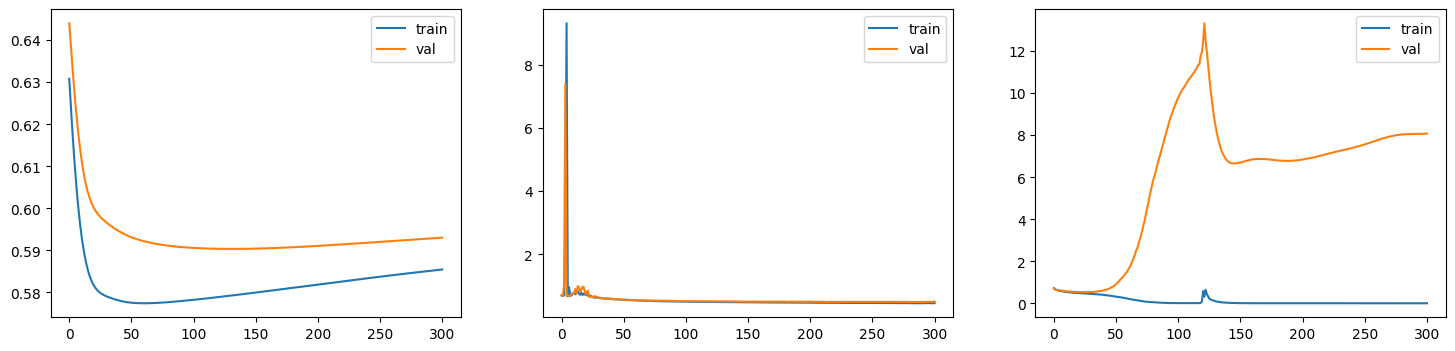

In [120]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

plot_train_val_metric(lgc_stats_added_features, metric="loss", ax=axs[0])
plot_train_val_metric(gat_stats_added_features, metric="loss", ax=axs[1])
plot_train_val_metric(sage_stats_added_features, metric="loss", ax=axs[2])

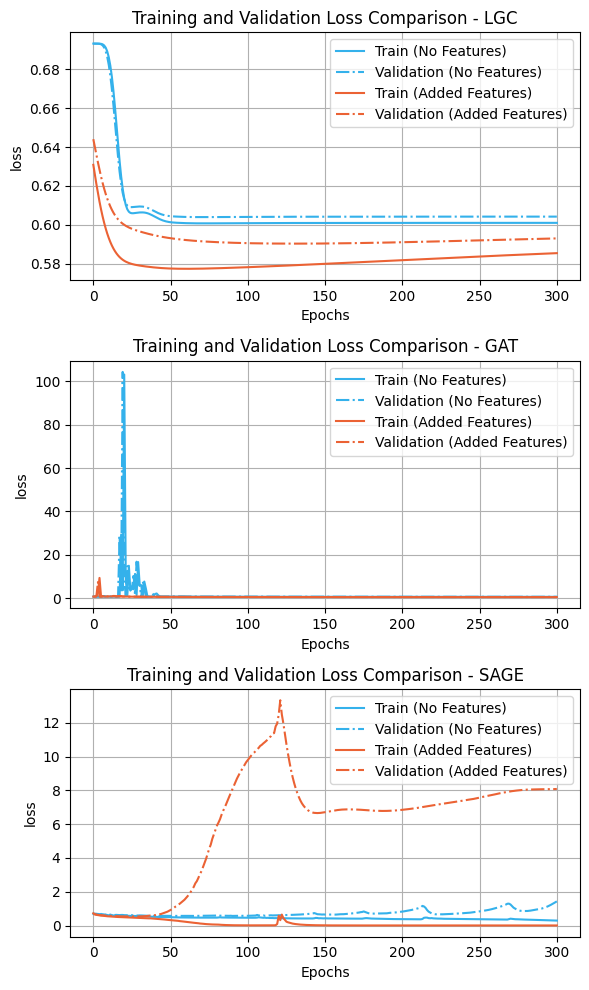

In [121]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

compare_features_plot(lgc_stats_no_features, lgc_stats_added_features, "LGC", metric="loss", ax=axs[0])
compare_features_plot(gat_stats_no_features, gat_stats_added_features, "GAT", metric="loss", ax=axs[1])
compare_features_plot(sage_stats_no_features, sage_stats_added_features, "SAGE", metric="loss", ax=axs[2])

plt.savefig("plots/loss_comparison.pdf", dpi=300, bbox_inches="tight")

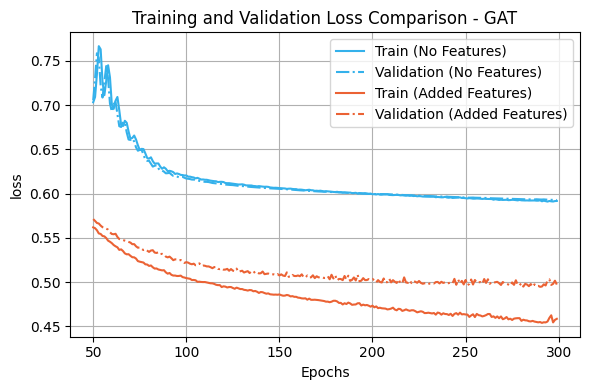

In [122]:
compare_features_plot(gat_stats_no_features, gat_stats_added_features, "GAT", metric="loss", epochs=[50, 300])

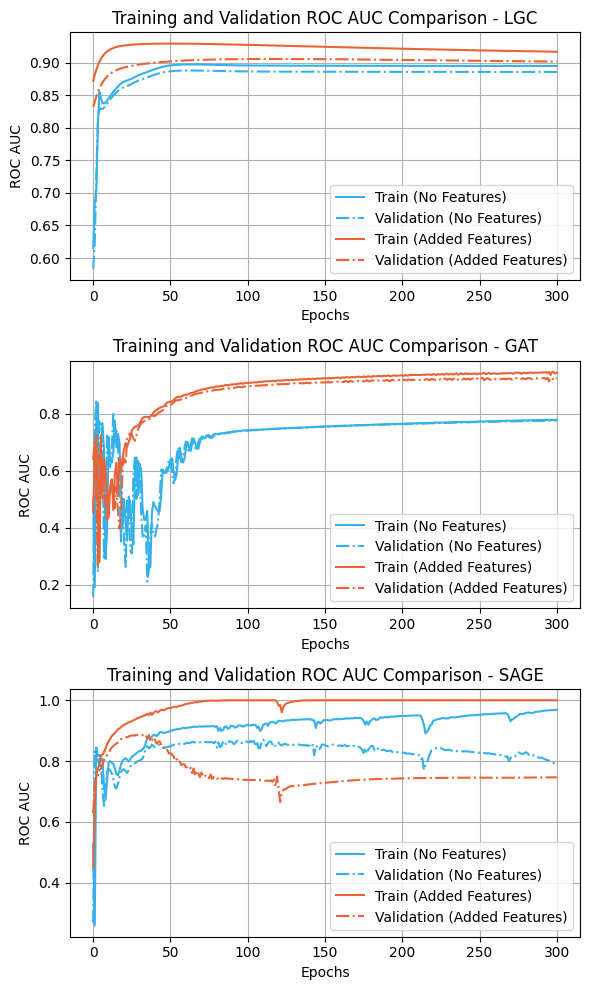

In [131]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

compare_features_plot(lgc_stats_no_features, lgc_stats_added_features, "LGC", metric="roc", ax=axs[0])
compare_features_plot(gat_stats_no_features, gat_stats_added_features, "GAT", metric="roc", ax=axs[1])
compare_features_plot(sage_stats_no_features, sage_stats_added_features, "SAGE", metric="roc", ax=axs[2])

plt.savefig("plots/roc_comparison.pdf", dpi=300, bbox_inches="tight")

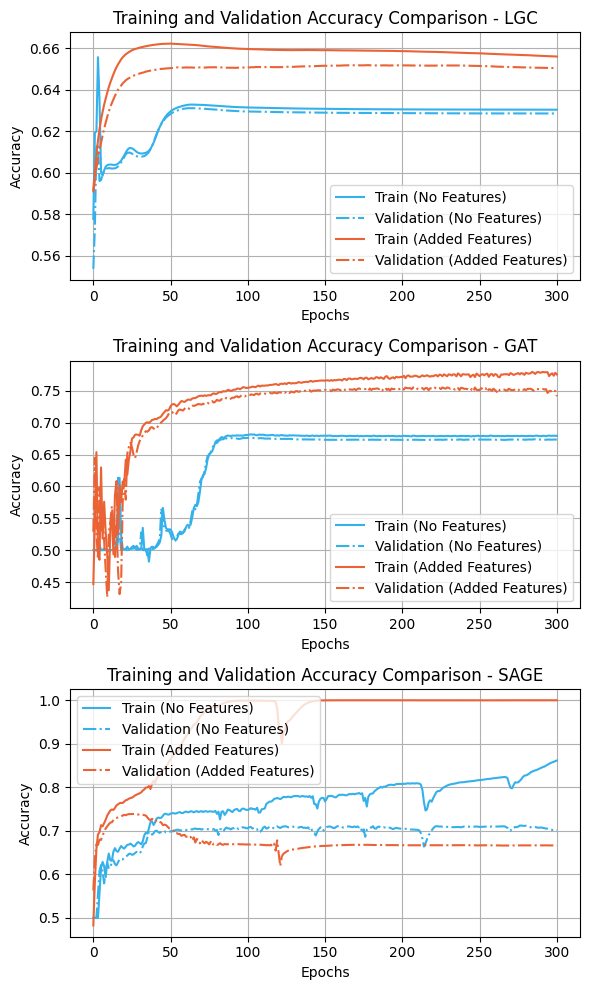

In [132]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

compare_features_plot(lgc_stats_no_features, lgc_stats_added_features, "LGC", metric="acc", ax=axs[0])
compare_features_plot(gat_stats_no_features, gat_stats_added_features, "GAT", metric="acc", ax=axs[1])
compare_features_plot(sage_stats_no_features, sage_stats_added_features, "SAGE", metric="acc", ax=axs[2])

plt.savefig("plots/acc_comparison.pdf", dpi=300, bbox_inches="tight")

## Inference on Test set

In [125]:
# load models and evaluate on test set
def load_model(conv_layer, args, added_features, directory = "model_stats_final"):
  num_nodes = 35300
  model = GCN(
      num_nodes = num_nodes, num_layers = args['num_layers'],
      embedding_dim = args["emb_size"], conv_layer = conv_layer
  )
  model.load_state_dict(torch.load(f"{directory}/{model.name}_{loss_fn}_{neg_samp}_{added_features}.pt"))
  model.to(args["device"])
  return model

In [126]:
results = {}

model_names = ["LGC", "GAT", "SAGE"]
features_flags = ["no_features", "added_features"]
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  3,
    'emb_size' : 78, # CHANGED FROM 64
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 301 # change!
}
loss_fn = "BPR"
neg_samp = "random"

for model_name in model_names:
    for features_flag in features_flags:
        model = load_model(model_name, args, features_flag)
        model.eval()

        _, roc, acc, _, _ = test(model, datasets["test"], loss_fn, neg_samp)
        results[f"{model_name}_{features_flag}"] = {"roc": roc, "acc": acc}

results

Best threshold: 0.125
Best threshold: 0.16666666666666666
Best threshold: 0.0
Best threshold: 0.7083333333333333
Best threshold: 0.8333333333333333
Best threshold: 1.0


{'LGC_no_features': {'roc': 0.8807235951755131, 'acc': 0.7994681423920338},
 'LGC_added_features': {'roc': 0.8985012642610637, 'acc': 0.8193092478605573},
 'GAT_no_features': {'roc': 0.7384993576188876, 'acc': 0.6713791018068247},
 'GAT_added_features': {'roc': 0.8922876848253076, 'acc': 0.8290351175140214},
 'SAGE_no_features': {'roc': 0.7070163498763382, 'acc': 0.6649421335608778},
 'SAGE_added_features': {'roc': 0.687635274170822, 'acc': 0.6428725281462029}}